In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

In [29]:
data = pd.read_csv('city_temperature.csv', header='infer',encoding='latin1')

ciudades = pd.read_csv('fechas_olimpiadas_limpias.csv', header='infer')['City'].unique()

data_filtered = data[data['City'].isin(ciudades)]
data_filtered = data_filtered[['City', 'Day', 'Month', 'Year', 'AvgTemperature']]

data_filtered['AvgTemperature'] = data_filtered['AvgTemperature'].replace(-99, float('NaN'))
data_filtered = data_filtered.dropna(subset=['AvgTemperature'])


C:\Users\Fran\AppData\Local\Temp\ipykernel_28700\4262325586.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('city_temperature.csv', header='infer',encoding='latin1')


In [138]:
city_models = {}
rsq_values = []

for country in data_filtered['City'].unique():
    data_country = data_filtered[data_filtered['City'] == country]
    # split the data into training and testing sets
    X = data_country[['Day', 'Month', 'Year']]
    Y = data_country['AvgTemperature']
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # create a Random Forest regressor and fit the training data
    rf = RandomForestRegressor(n_estimators=112, random_state=42)
    rf.fit(X_train, y_train)

    # predict on the test data and calculate the evaluation metrics
    y_pred = rf.predict(X_test)
    rsq = rf.score(X_test, y_test)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    rsq_values.append(rsq)

    city_models[country] = rf

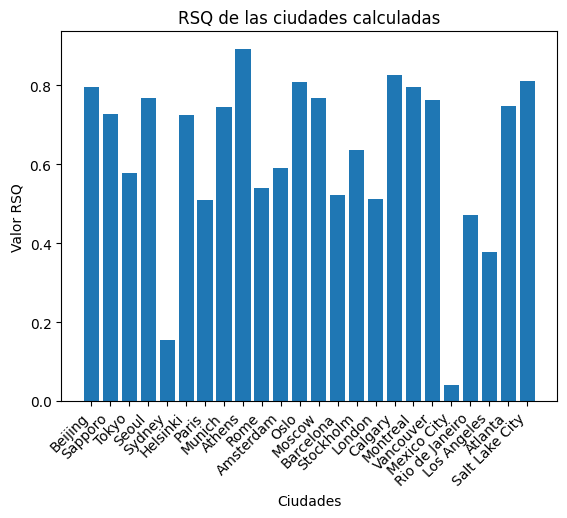

In [148]:
import matplotlib.pyplot as plt

plt.bar(city_models.keys(), rsq_values)
plt.xlabel('Ciudades')
plt.ylabel('Valor RSQ')
plt.title('RSQ de las ciudades calculadas')

# Establecer la posición y etiquetas de las marcas del eje x
plt.xticks(rotation=45, ha='right')

plt.show()


In [108]:
ciudades = pd.read_csv('fechas_olimpiadas_limpias.csv', header='infer')['City'].unique()
data_filtered = data[data['City'].isin(ciudades)]

ciudades_desconocidas = np.setdiff1d(ciudades, data_filtered['City'].unique())

nombres_columnas = []
localizacion_ciudades = pd.read_csv('cities15000.txt', delimiter='\t', header=None)
localizacion_ciudades = localizacion_ciudades.iloc[:, [1,2,3,4,5]]

ciudades_todas = np.concatenate((data['City'].unique(), ciudades_desconocidas))

localizacion_ciudades_filtered = localizacion_ciudades[localizacion_ciudades[2].isin(ciudades_todas)]

# Seleccionar las columnas relevantes (nombre, latitud y longitud)
df = localizacion_ciudades_filtered.iloc[:, [1, 3, 4]]

# Crear un diccionario de mapeo para los nuevos nombres de columnas
nuevos_nombres = {2: 'Ciudad', 4: 'Latitud', 5: 'Longitud'}

# Renombrar las columnas usando el método rename()
df = df.rename(columns=nuevos_nombres)

# Función para calcular la distancia euclidiana entre dos coordenadas geográficas
def distancia_geodesica(lat1, lon1, lat2, lon2):
    # Radio de la Tierra en km
    R = 6371
    # Convertir las coordenadas de grados a radianes
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    # Calcular la distancia euclidiana entre las coordenadas
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

# Función para encontrar el país más cercano a una ciudad dada
def encontrar_pais_cercano(ciudad, paises):
    # Buscar las coordenadas geográficas de la ciudad dada
    ci, latitud_ciudad, longitud_ciudad = df.loc[df['Ciudad'] == ciudad][0:].values[0]
    # Inicializar la distancia mínima como infinito y el país más cercano como None
    distancia_minima = np.inf
    pais_mas_cercano = None

    # Calcular la distancia entre la ciudad dada y cada uno de los países en el array
    for pais in paises:
        # Buscar las coordenadas geográficas del país actual
        if df['Ciudad'].isin([pais]).any():
            ci, latitud_pais, longitud_pais = df.loc[df['Ciudad'] == pais][0:].values[0]
            # Calcular la distancia geodésica entre la ciudad y el país actual
            distancia_actual = distancia_geodesica(latitud_ciudad, longitud_ciudad, latitud_pais, longitud_pais)
            # Actualizar la distancia mínima y el país más cercano si la distancia actual es menor
            if distancia_actual < distancia_minima:
                distancia_minima = distancia_actual
                pais_mas_cercano = pais

    return pais_mas_cercano

# Ejemplo de uso
ciudad = "Barcelona"
pais_cercano = encontrar_pais_cercano(ciudad, ciudades)
print("El país más cercano a", ciudad, "es", pais_cercano)





El país más cercano a Barcelona es Barcelona


In [133]:
ciudades_emparejadas = {}

for city in ciudades_desconocidas:
    ciudad = city
    if not df['Ciudad'].isin([ciudad]).any():
        pais_cercano = "No encontrado"
    else:
        pais_cercano = encontrar_pais_cercano(ciudad, data['City'].unique())
    
    ciudades_emparejadas[city] = pais_cercano

print(ciudades_emparejadas)

{'Albertville': 'Macon', 'Antwerp': 'No encontrado', 'Berlin': 'Hamburg', 'Chamonix': 'No encontrado', "Cortina d'Ampezzo": 'No encontrado', 'Garmisch-Partenkirchen': 'Munich', 'Grenoble': 'Macon', 'Innsbruck': 'Munich', 'Lake Placid': 'No encontrado', 'Lillehammer': 'Oslo', 'Nagano': 'Tokyo', 'Pyeongchang': 'No encontrado', 'Sarajevo': 'Belgrade', 'Sochi': 'Tbilisi', 'Squaw Valley': 'No encontrado', 'St. Louis': 'Concord', 'St. Moritz': 'No encontrado', 'Turin': 'Milan'}


## All available cities

In [149]:
city_models_2 = {}
rsq_values_2 = []

for ciudad in ciudades_desconocidas:

    country = ciudades_emparejadas[ciudad]

    rf = None

    if country != "No encontrado":

        data_country = data[data['City'] == country]
        # split the data into training and testing sets
        X = data_country[['Day', 'Month', 'Year']]
        Y = data_country['AvgTemperature']
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

        # create a Random Forest regressor and fit the training data
        rf = RandomForestRegressor(n_estimators=112, random_state=42)
        rf.fit(X_train, y_train)

        # predict on the test data and calculate the evaluation metrics
        y_pred = rf.predict(X_test)
        rsq = rf.score(X_test, y_test)
        rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
        rsq_values_2.append(rsq)

        city_models_2[country] = rf

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (33,) and arg 1 with shape (35,).

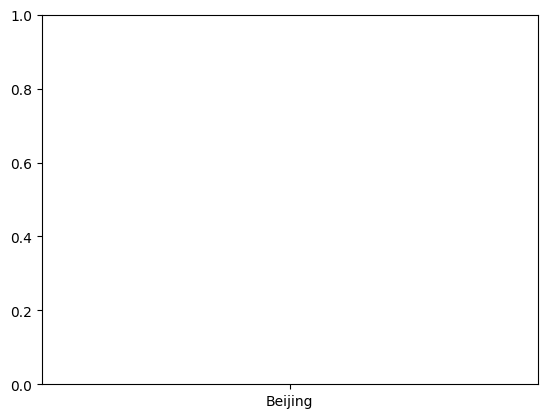

In [153]:
import matplotlib.pyplot as plt

city_models_all = list(city_models.keys()) + list(city_models_2.keys())

rsq_values_all = rsq_values + rsq_values_2

plt.bar(city_models_all, rsq_values_all)
plt.xlabel('Ciudades')
plt.ylabel('Valor RSQ')
plt.title('RSQ de las ciudades calculadas')

# Establecer la posición y etiquetas de las marcas del eje x
plt.xticks(rotation=45, ha='right')

plt.show()